In [7]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L
import os
import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

In [5]:
def goOneUp():
    path_parent = os.path.dirname(os.getcwd())

    os.chdir(path_parent)
    os.getcwd()
goOneUp()

In [24]:
os.getcwd()
#os.chdir("bc_deep_learning_in_biology")
#!cd "bc_deep_learning_in_biology"

'/home/course/bc_deep_learning_in_biology'

In [25]:
# the dataloaders load the tensors from memory one by one, could potentially become a bottleneck

class ProtEmbeddingDataset(Dataset):
    """
    Dataset for the embeddings of the mutated sequences
    You can the get_item() method to return the data in the format you want
    """
    def __init__(self, tensor_folder, csv_file, id_col="name", label_col="ddG_ML"):
        """
        Initialize the dataset
        input at init: 
            tensor_folder: path to the directory with the embeddings we want to use, eg. "/home/data/mega_train_embeddings"
            cvs_file: path to the csv file corresponding to the data, eg. "home/data/mega_train.csv"
        """
        self.tensor_folder = tensor_folder
        self.df = pd.read_csv(csv_file, sep=",")
        # only use the mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # get the labels and ids
        self.labels = torch.tensor(self.df[label_col].values)
        self.ids = self.df[id_col].values
        self.wt_names = self.df["WT_name"].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # load embeddings
        # mutation embedding
        tensor_path = os.path.join(self.tensor_folder, self.ids[idx] + ".pt")
        tensor = torch.load(tensor_path)['mean_representations'][6]
        # wildtype embedding, uncomment if you want to use this, too
        #tensor_path_wt = os.path.join(self.tensor_folder, self.wt_names[idx] + ".pt")
        #tensor_wt = torch.load(tensor_path_wt)['mean_representations'][6]
        label = self.labels[idx] # ddG value
        # returns a tuple of the input embedding and the target ddG values
        return tensor, label.float()
    


In [26]:
# usage 
# make sure to adjust the paths to where your files are located
dataset_train = ProtEmbeddingDataset('project_data/mega_train_embeddings', 'project_data/mega_train.csv')
dataset_val = ProtEmbeddingDataset('project_data/mega_val_embeddings', 'project_data/mega_val.csv')
dataset_test = ProtEmbeddingDataset('project_data/mega_test_embeddings', 'project_data/mega_test.csv')

dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True, num_workers=16)
dataloader_val = DataLoader(dataset_val, batch_size=512, shuffle=False, num_workers=16)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [27]:
# take first batch from the train loader
batch = next(iter(dataloader_train))

In [28]:
batch[0].shape

torch.Size([1024, 768])

In [39]:
# your code
class MRIModel(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(MRIModel, self).__init__() #initialize parent pytorch module
        
        # read parameters
        shape_in = params["shape_in"]
        batch_size = params["batch_size"] 
        #fc1_size = params["fc1_size"]
        
        #### Convolution Layers
        self.dropout = nn.Dropout(0.3)
        
        #### Fully connected layers
        # compute the flattened size as input for fully connected layer
        #flat_size = current_data_shape[1] * batch_size
        #print(current_data_shape)
        # linear layer reduces data from flat_size to fc1_size
        self.fc1 = nn.Linear(shape_in[1], shape_in[1])
        print("first linear", shape_in[1])
        # last linear layer reduces data to output size 1
        self.fc2 = nn.Linear(shape_in[1], 1)  #640
        print("second linear", shape_in[1])
        ##self.fc3 = nn.Linear(shape_in[1], 640) #640, 512
        #print("third linear", shape_in[1])
        ##self.fc4 = nn.Linear(640, 512) #512, 384
        #print("forth linear", shape_in[1])
        ##self.fc5 = nn.Linear(512, 1) #384, 1
        #print("last linear", shape_in[1])
        #self.fc6 = nn.Linear(384, 1)
        #####################################
        

    def forward(self, X):
        # our network's forward pass
        X = F.sigmoid(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        #X = self.dropout(X)
        #X = F.sigmoid(self.fc3(X))
        #X = self.dropout(X)
        #X = F.sigmoid(self.fc4(X))
        #X = self.dropout(X)
        #X = self.fc5(X)
        #X = self.fc6(X)

        #####################################
        # return log softmax to fit classification problem, no relu needed
        return X

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LitMRIModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        ######## TODO ##########
        # pass our model 
        self.model = model
        #pass the learning rate
        self.lr = learning_rate
        # define loss function
        
        self.loss_function = nn.MSELoss(reduction="mean")
        # define accuracy metric (torchmetrics)
        #self.accuracy = torchmetrics.classification.MulticlassAccuracy() #change
        ########################

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        ######### TODO #############
        
        # read from batch
        x, y = batch
        x = torch.unsqueeze(x, 1)
        # run data through model
        predictions = self.model(x)
        predictions = predictions.squeeze(1).squeeze(1)
        # compute loss
        loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions, y)
        ##############################

        # logging the values (will appear in progress bar and on dashboard)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        ############## TODO ################
        # define the optimizer, let's use Adam
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        ####################################
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop

        ############### TODO #############
        # read from batch
        x, y = batch
        x = torch.unsqueeze(x, 1)
        # run data through model
        predictions = self.model(x)
        predictions = predictions.squeeze(1).squeeze(1)
        # compute loss
        loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("test_loss", loss, prog_bar=True)
        #self.log("test_acc", acc, prog_bar=True)
        return loss#, acc


    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        ############### TODO #############
        # read from batch
        x, y = batch
        x = torch.unsqueeze(x, 1)
        # run data through model
        predictions = self.model(x)
        predictions = predictions.squeeze(1).squeeze(1)
        # compute loss
        loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss 
    

In [41]:
params_model={"shape_in": (1, batch[0].shape[1]), # size of our dataset  1024 (batch size), - 768 (nr of neurons)
        "batch_size": 1024} #1 - 2x192, 384x7
        #"fc1_size": 7}

# Instantiate the model
cnn_model = MRIModel(params_model)
# instantiate lightning model with the cnn_model and learning_rate=1e-3
model = LitMRIModel(cnn_model, learning_rate=1e-3)
############################

# instantiate the lightning trainer 
trainer = L.Trainer(max_epochs=15, log_every_n_steps=1)
# train
trainer.fit(model, dataloader_train, dataloader_val)

trainer.validate(model, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | model         | MRIModel | 591 K 
1 | loss_function | MSELoss  | 0     
-------------------------------------------
591 K     Trainable params
0         Non-trainable params
591 K     Total params
2.365     Total estimated model params size (MB)


first linear 768
second linear 768


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.5234174728393555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.5234174728393555}]

In [42]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/ --host localhost --port=8009

RMSE: 1.2412875
Pearson r: PearsonRResult(statistic=0.24132408752754578, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.21465936137234473, pvalue=2.7030435635330434e-282)


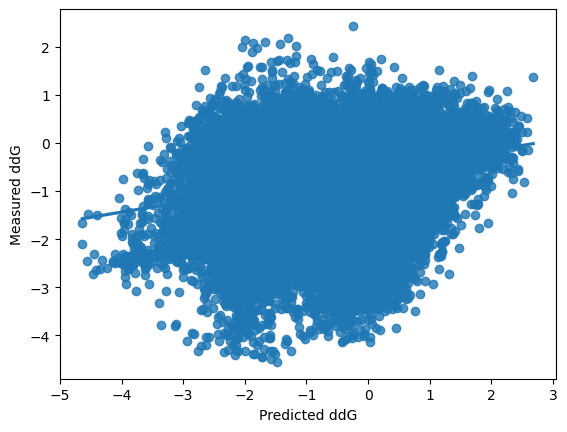

In [44]:
preds =[]
all_y = []
# save all predictions
for batch in dataloader_val:
    # adjust this to work with your model
    x,y = batch
    x = torch.unsqueeze(x, 1)
    y_hat = cnn_model(x)
    preds.append(y_hat.squeeze().detach().numpy())
    all_y.append(y.detach().numpy())

# concatenate and plot
preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared = False))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))